## Importing the necessary libraries and setting of global variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer # noqa
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
pd.options.display.max_columns = None

# Global varaibles
CORR_THRESHOLD = 0.10
FEATURE_COLUMNS = []
column_names = ['Dataset', 'Imputation Algorithm', 'Strategy', 'n_nearest_features','Train r^2 score', 'Prediction r^2 score']
RESULTS_SUMMARY = pd.DataFrame(columns=column_names)

### Helper Functions

In [3]:
# Drop a fraction of columns
def drop_column_frac(df:pd.DataFrame, column_name:str, replace_with, drop_frac=0.1) -> pd.DataFrame:
    drop_idx = df[column_name].sample(frac=drop_frac).index
    dropped_df = df.copy()
    dropped_df.loc[drop_idx, column_name] = replace_with
    return dropped_df

# Drop columns 
def drop_columns(df:pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    return df.drop(columns=columns_to_drop)

# Drop NAs
def drop_nas(df:pd.DataFrame) -> pd.DataFrame:
    return df.dropna()

# Returns best_score_, best_params_, grid_search object
def grid_search(X:np.array, y:np.array, pipeline: Pipeline, params_grid: dict, n_jobs=10) -> (float, dict, float):
    search = GridSearchCV(pipeline, params_grid, n_jobs=n_jobs)
    search.fit(X, y)
    return search.best_score_, search.best_params_, search

# Run pipeline
def run_pipeline(X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array, pipeline: Pipeline, params_grid: dict) -> [float, float]:
    # Set Parameters
    pipeline.set_params(**params_grid)
    # Fit data
    pipeline.fit(X_train, y_train)
    # Predict data
    y_predicted = pipeline.predict(X_test)
    # Calculate scores
  
    mean_error = mean_squared_error(y_test, y_predicted)
    rms = mean_squared_error(y_test, y_predicted, squared=False)
    r2_score_val = r2_score(y_test, y_predicted)

    return  mean_error, rms, r2_score_val

# Zillow Dataset

## Data Preprocessing on Zillow Data

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

# Using training data set since the properties datasets are HUGE
zillow_df = pd.read_csv('/content/drive/My Drive/properties_2016_small.csv')

#Set true target
TRUE_TARGET = 'taxvaluedollarcnt'

# Check the data
zillow_df.head(15)


Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,NaN,2400.0,NaN,NaN,2400.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171873.0,-118380906.0,2500.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAC4,6.037125e+07,12447.0,3101.0,46795.0,96446.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1943.0,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34131929.0,-118351474.0,NaN,NaN,NaN,NaN,NaN,NaN,010V,260.0,LAC2,6.037144e+07,12447.0,3101.0,274049.0,96049.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3611.0,NaN,NaN,3611.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34171345.0,-118314900.0,5333.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,BUC4YY,6.037311e+07,396054.0,3101.0,NaN,96434.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1946.0,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34218210.0,-118331311.0,145865.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,BUR1*,6.037310e+07,396054.0,3101.0,NaN,96436.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,3754.0,NaN,NaN,3754.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34289776.0,-118432085.0,7494.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,SFC2*,6.037320e+07,47547.0,3101.0,NaN,96366.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1978.0,1.0

In [5]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50000 non-null  int64  
 1   airconditioningtypeid         13956 non-null  float64
 2   architecturalstyletypeid      98 non-null     float64
 3   basementsqft                  30 non-null     float64
 4   bathroomcnt                   50000 non-null  float64
 5   bedroomcnt                    50000 non-null  float64
 6   buildingclasstypeid           253 non-null    float64
 7   buildingqualitytypeid         33170 non-null  float64
 8   calculatedbathnbr             47845 non-null  float64
 9   decktypeid                    330 non-null    float64
 10  finishedfloor1squarefeet      3913 non-null   float64
 11  calculatedfinishedsquarefeet  49271 non-null  float64
 12  finishedsquarefeet12          45559 non-null  float64
 13  f

In [6]:
# Print the value counts for categorical columns
for col in zillow_df.columns:
    if zillow_df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(zillow_df[col].value_counts())


Column Name: hashottuborspa
True    1082
Name: hashottuborspa, dtype: int64

Column Name: propertycountylandusecode
0100    19608
122      7862
0101     4447
010C     3876
1111     2440
        ...  
0141        1
0401        1
020M        1
0102        1
0131        1
Name: propertycountylandusecode, Length: 99, dtype: int64

Column Name: propertyzoningdesc
LAR1          5090
LAR3          1190
LARS          1045
LAR2           858
LBR1N          780
              ... 
SPR3A10000       1
SPR1-R3*         1
SPR2A1OOOO       1
SOR1YY           1
SLC1*            1
Name: propertyzoningdesc, Length: 1773, dtype: int64

Column Name: fireplaceflag
True    79
Name: fireplaceflag, dtype: int64

Column Name: taxdelinquencyflag
Y    982
Name: taxdelinquencyflag, dtype: int64


### Drop all categorical data 

In [7]:
# Select the categorical columns
cat_cols = zillow_df.select_dtypes(include='object').columns

# Drop the columns
zillow_df = zillow_df.drop(columns=cat_cols)

### Calculate correlation coefficients against target column

In [8]:
correlation_array = zillow_df.corr()[TRUE_TARGET].sort_values(ascending=False)
correlation_array

taxvaluedollarcnt               1.000000
taxamount                       0.963647
landtaxvaluedollarcnt           0.847662
structuretaxvaluedollarcnt      0.834219
finishedsquarefeet15            0.658055
finishedsquarefeet12            0.636250
finishedfloor1squarefeet        0.574428
finishedsquarefeet50            0.565945
poolsizesum                     0.520322
calculatedfinishedsquarefeet    0.509469
calculatedbathnbr               0.495457
fullbathcnt                     0.481303
basementsqft                    0.465104
fireplacecnt                    0.454990
garagecarcnt                    0.369250
bathroomcnt                     0.360499
garagetotalsqft                 0.356908
threequarterbathnbr             0.348244
yardbuildingsqft17              0.289622
unitcnt                         0.197026
finishedsquarefeet6             0.178706
numberofstories                 0.175817
bedroomcnt                      0.161504
finishedsquarefeet13            0.158479
yearbuilt       

In [9]:
CORR_THRESHOLD = 0.2

### Drop redudant features

In [10]:
# Only keep colms that have correlation coeff greater than CORR_THRESHOLD
colms_to_keep = correlation_array[correlation_array > CORR_THRESHOLD]
# Only keep the best correlated columns
parsed_zillow_df = zillow_df[colms_to_keep.index]

### Number of NAN values in target column

In [11]:
# Number of NANs in target column
num_nan = parsed_zillow_df[TRUE_TARGET].isna().sum()
print('Number of NANs in target column is: ', num_nan)

Number of NANs in target column is:  617


### Drop rows with NAN values in target column

In [12]:
# Drop rows with NAN in target column
parsed_zillow_df = parsed_zillow_df.dropna(subset=[TRUE_TARGET], how='any')
# Shuffle data
parsed_zillow_df = parsed_zillow_df.sample(frac=1)
print('Shape of data after dropping NAN values in target column: ', parsed_zillow_df.shape)

Shape of data after dropping NAN values in target column:  (49383, 19)


### Generate correlation map for missing values in feature matrix

In [13]:
# Function to plot correlation for variables with NAN values
def correlationMatrix(df, dropDuplicates = True):
    """Plot correlation matrix"""
    # Calculate correlation
    df_corr = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df_corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df_corr, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df_corr, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

### Create feature and target matrix

In [14]:
# Extract target
target = parsed_zillow_df[TRUE_TARGET]

# Extract features
X_original = parsed_zillow_df.drop(columns=[TRUE_TARGET])

# Columns to be used for pair plots
FEATURE_COLUMNS = X_original.columns.to_numpy()

# Check the structure of the data
print('Shape of feature matrix: ', X_original.shape)
print('Shape of target matrix: ', target.shape)

Shape of feature matrix:  (49383, 18)
Shape of target matrix:  (49383,)


In [15]:
# Columns of rows with NAN values
nan_values = X_original.isna()
nan_columns = nan_values.any()

# Dataframe with columns that have got NAN values
X_original_nan = X_original[(nan_columns[nan_columns == True]).index]

In [16]:
X_original_nan.shape

(49383, 17)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


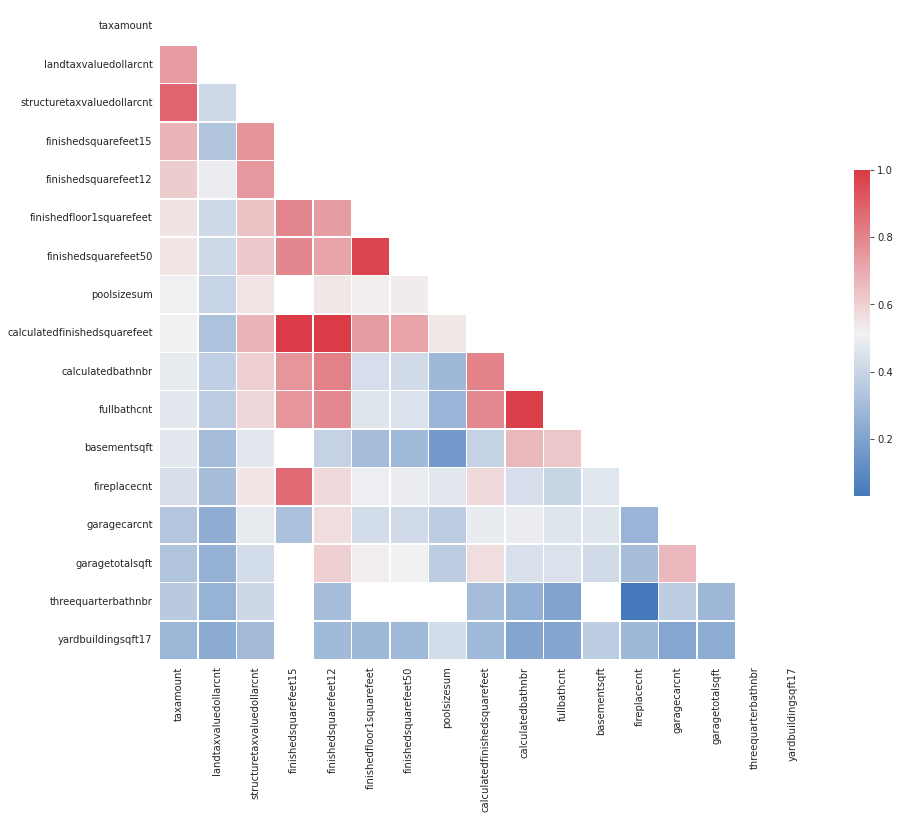

In [17]:
# Plot the correlation matrix for the variables containing NAN values
# This will help us determine the variables whose covariance is likely to be affected after
# imputation and also which varibales can be used together when imputing
correlationMatrix(X_original_nan, dropDuplicates = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


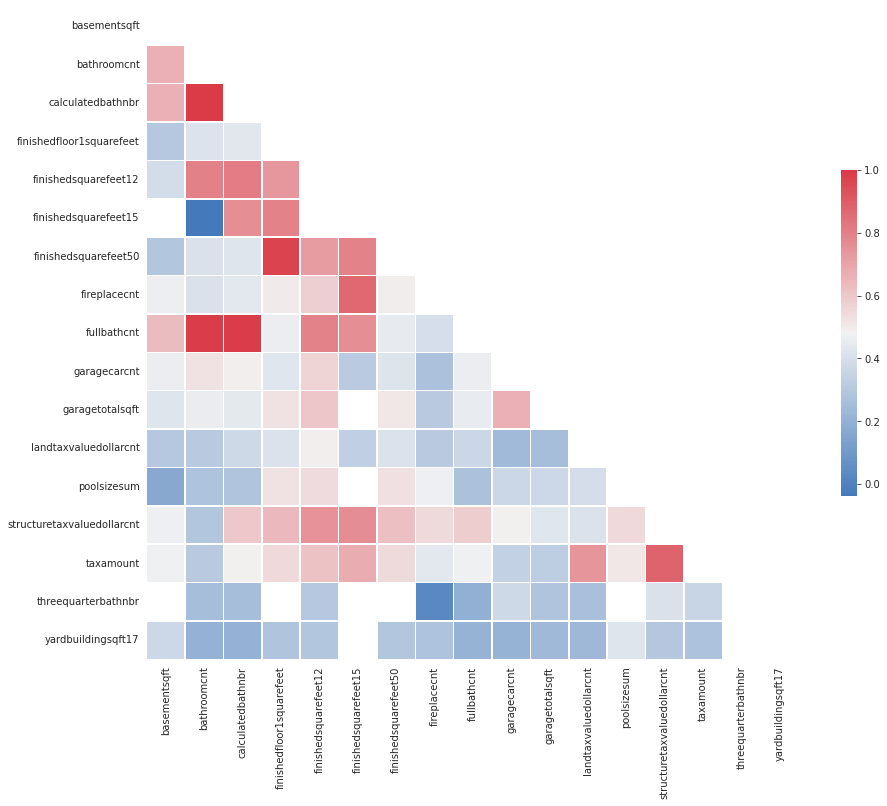

In [18]:
correlationMatrix(X_original[X_original.columns.difference(['calculatedfinishedsquarefeet'])], dropDuplicates = True)

In [19]:
X_original = X_original.drop(columns=['calculatedfinishedsquarefeet', 'finishedsquarefeet50'])

In [20]:
X_original.shape

(49383, 16)

# Multivariate Imputation on Zillow Data
Before getting into using various models to perform imputation, we prform mean imputation to create a base for comparison for our models. We then use the state of the art MICE imputation and finally we perform imputation using the various chosen models. 

## MICE with MLPRegressor Regressor
### Hyperparameter tuning for MLPRegressr model

In [21]:
# Copy feature matrix
X_missing_mlp = X_original.copy()

# Parameters
param_grid_mlp = {'iterativeimputer__n_nearest_features': [1, 3], 'iterativeimputer__estimator__hidden_layer_sizes':  [10, 30, 50, 80, 100, 150],
                 'iterativeimputer__estimator__alpha': [0.001, 0.0001], 'iterativeimputer__estimator__learning_rate':['constant', 'adaptive'],
                  'iterativeimputer__estimator__tol': [0.001, 0.0001], 'iterativeimputer__estimator__early_stopping':[True],
                  'iterativeimputer__estimator__activation':['relu','logistic'], 'iterativeimputer__estimator__max_iter': [200, 300, 500],
                  'iterativeimputer__estimator__learning_rate_init':[0.01,0.001]}

# Regressor
br_estimator_mlp = BayesianRidge()
# Instantiate knn imputer
iterative_imputer_mlp = IterativeImputer(estimator=MLPRegressor())
# Scaler
scaler_mlp = StandardScaler()
# Estimator
estimator_mlp = make_pipeline(iterative_imputer_mlp, scaler_mlp, br_estimator_mlp)
# Grid search
grid_iterative_imputer_score_mlp, grid_iterative_imputer_params_mlp, grid_iterative_search_mlp = grid_search(X_missing_mlp, target, estimator_mlp, param_grid_mlp)
print('Best MLPRegressor imputer paramemeters: ' , grid_iterative_imputer_params_mlp)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored